In [3]:
!pip install easydict
!pip install mlflow
!pip install python-mnist

In [4]:
import os
# print(os.listdir('/kaggle/input/cifar10-python/cifar-10-batches-py'))
# print(os.listdir('/kaggle/input/mnist-pytorch/'))
print(os.listdir('/kaggle/input/segm-data'))

['t10k-labels-idx1-ubyte', 'data_batch_1', 't10k-images-idx3-ubyte', 'data_batch_2', 'batches.meta', 'test_batch', 'data_batch_3', 'data_batch_5', 'data_batch_4', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [5]:
""" config """

from easydict import EasyDict

cfg = EasyDict()
cfg.datasets = EasyDict()
cfg.datasets.train = EasyDict()
cfg.datasets.valid = EasyDict()

# data params
cfg.num_classes = 2
cfg.in_channels = 3
cfg.pad = (20, 20)
cfg.mean = [0.485, 0.456, 0.406]  # [0.471, 0.448, 0.408]
cfg.std = [0.229, 0.224, 0.225]  # [0.234, 0.239, 0.242]
cfg.weights_path = 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/class_weights.pickle'
cfg.datasets.train.root = '/kaggle/input/segm-data/'  # 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/cifar-10-batches-py/'
cfg.datasets.train.annFile = '/kaggle/input/segm-data/'  # 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/MNIST/raw/'
cfg.datasets.valid.root = '/kaggle/input/segm-data/'  # 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/cifar-10-batches-py/'
cfg.datasets.valid.annFile = '/kaggle/input/segm-data/'  # 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/MNIST/raw/'
cfg.images_path = 'D:/datasets/homeworks/cv segmentation(synthetic_dataset)/saved_images/'

# training params
cfg.lr = 0.001
cfg.momentum = 0.99
cfg.weight_decay = 1e-4
cfg.nesterov = True
cfg.batch_size = 1
cfg.epochs = 100

# evaluation params
cfg.evaluate_before_training = True
cfg.evaluate_on_train_data = True

# overfit on batch params
cfg.overfit_on_batch = True
cfg.overfit_on_batch_iters = 10000

# mlflow params
cfg.log_metrics = True
cfg.experiment_name = 'segmentation (synthetic data)'

# tensorboard
cfg.use_tensorboard = False
cfg.tensorboard_dir = ''  # 'tensorboard/'

# model store/restore params
cfg.load_model = False
cfg.epoch_to_load = 0
cfg.checkpoints_dir = ''
cfg.save_model = True
cfg.save_frequency = 1

In [6]:
""" mnist_cifar_api.py """
import pickle
import numpy as np
import os
from os.path import join, exists
from mnist import MNIST
# np.random.seed(0)


def unpickle(file):
    """
    unpickles cifar batches from the encoded files. Code from
    https://www.cs.toronto.edu/~kriz/cifar.html
    :param file:
    :return:
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def unpack_cifar(direc, dataset_type):
    """
    the data comes in batches. So this function concatenates the data from the batches
    :param direc: directory where the batches are located
    :return:
    """
#     assert exists(direc), "directory does not exist"
    X, y = [], []
    for filename in os.listdir(direc):
        if (dataset_type == 'train' and filename[:5] == 'data_') or \
                (dataset_type == 'valid' and filename[:5] == 'test_'):
            data = unpickle(join(direc, filename))
            X.append(data[b'data'].reshape((10000, 3, 32, 32)))
            y += data[b'labels']
#     assert X, "No data was found in '%s'. Are you sure the CIFAR10 data is there?" % direc

    X = np.concatenate(X, 0)
    X = np.transpose(X, (0, 2, 3, 1)).astype(np.float32)
    return X, y


def unpack_mnist(direc, dataset_type):
    """
    Unpack the MNIST data and put them in numpy arrays
    :param direc:
    :return:
    """
    assert exists(direc), "directory does not exist"
    try:
        mndata = MNIST(direc)
        if dataset_type == 'train':
            images, labels = mndata.load_training()
        else:
            images, labels = mndata.load_testing()
    except FileNotFoundError as e:
        print('Make sure that you have downloaded the data and put in %s\n Also make sure that the spelling is correct. \
              the MNIST data comes in t10k-images.idx3-ubyte or t10k-images-idx3-ubyte. We expect the latter' % (direc))
        raise FileNotFoundError(e)
    X_mnist = np.array(images).reshape(len(labels), 28, 28)
    y_mnist = np.array(labels)
    X_mnist = X_mnist.astype(np.float32) / np.max(X_mnist)
    return X_mnist, y_mnist


class Datagen():
    """
    Object to sample the data that we can segment. The sample function combines data
    from MNIST and CIFAR and overlaps them
    """

    def __init__(self, direc_mnist, direc_cifar, dataset_type):
        ## Unpack the data
        X_cifar, _ = unpack_cifar(direc_cifar, dataset_type)
        X_mnist, _ = unpack_mnist(direc_mnist, dataset_type)
        self.data = {}
        self.data['mnist'] = X_mnist
        self.data['cifar'] = X_cifar

    def sample(self, batch_size):
        """
        Samples a batch of data. It randomly inserts the MNIST images into cifar images
        :param batch_size:
        :param norm: indicate wether to normalize the data or not
        :return:
        """
        idx_cifar = np.random.choice(self.data['cifar'].shape[0], batch_size)
        idx_mnist = np.random.choice(self.data['mnist'].shape[0], batch_size)
        im_cifar = self.data['cifar'][idx_cifar]
        im_mnist = self.data['mnist'][idx_mnist][:, ::2, ::2]
        size_mnist = 14

        mnist_mask = np.greater(im_mnist, 0.3, dtype=np.float32)
        im_mnist *= mnist_mask

        width_start = np.random.randint(0, 32 - size_mnist, size=(batch_size))
        height_start = np.random.randint(0, 32 - size_mnist, size=(batch_size))

        color = [255, 0, 255]
        mnist_batch = np.repeat(np.expand_dims(im_mnist, 3), 3, 3) * color

        segm_maps = np.zeros((batch_size, 32, 32))

        for i in range(batch_size):
            im_cifar[i, width_start[i]:width_start[i] + size_mnist, height_start[i]:height_start[i] + size_mnist] += \
            mnist_batch[i]
            segm_maps[i, width_start[i]:width_start[i] + size_mnist, height_start[i]:height_start[i] + size_mnist] += \
            mnist_mask[i]
        im_cifar = np.clip(im_cifar, 0, 255)

        return im_cifar, segm_maps



In [7]:
""" mnist_cifar_dataset.py """

import os
import pickle
import numpy as np
import torch.utils.data as data
from torchvision import transforms
import torch

from sys import stdout
# from data.mnist_cifar_api import Datagen


class MNISTCIFARSegmentation(data.Dataset):
    """`MS Coco Captions <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.
    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self, config, dataset_type, transform=None, img_transform=None, target_transform=None):
        self.config = config
        if dataset_type == 'train':
            cifar_dataset = self.config.datasets.train.root
            mnist_dataset = self.config.datasets.train.annFile
        else:
            cifar_dataset = self.config.datasets.valid.root
            mnist_dataset = self.config.datasets.valid.annFile
        weights_path = self.config.weights_path
        self.datagen = Datagen(mnist_dataset, cifar_dataset, dataset_type)
        self.ids = np.arange(len(self.datagen.data['cifar']))
        self.transform = transform
        self.img_transform = img_transform
        self.target_transform = target_transform
        self.normalization = None
        # self.denorm = UnNormalize(self.config.mean, self.config.std)
        self.denorm = transforms.Normalize(
            mean=[-m / s for m, s in zip(self.config.mean, self.config.std)],
            std=[1 / s for s in self.config.std]
        )
        if dataset_type == 'train':
#             if os.path.exists(weights_path):
#                 with open(weights_path, 'rb') as f:
#                     self.W = pickle.load(f)
#             else:
#                 self.W = np.zeros(self.config.num_classes)
#                 print('Computing class weights matrix...')
#                 for i in range(len(self.ids)):
#                     stdout.write('\r%d/%d' % (i + 1, len(self.ids)))
#                     stdout.flush()
#                     _, target = self.datagen.sample(1)
#                     values, counts = np.unique(target, return_counts=True)
#                     self.W[values.astype(np.int32)] += counts
#                 with open(weights_path, 'wb') as f:
#                     pickle.dump(self.W, f)
#                 print()
            self.W = np.array([1.0, 1.0])
            # self.W /= np.sum(self.W)
            # self.W = 1 - self.W
        self.fixed_img, self.fixed_target = self.datagen.sample(1)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """

        imgs, targets = self.datagen.sample(1)
        # imgs, targets = self.fixed_img, self.fixed_target
        img = imgs[0].astype(np.uint8)
        target = targets[0].astype(np.int64)

        img_padded = np.pad(img, (self.config.pad, self.config.pad, (0, 0)), mode='reflect')

        self.img_transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(torch.tensor(self.config.mean),
                                                         torch.tensor(self.config.std))])

        if self.transform is not None:
            img, target = self.transform([img, target])

        if self.img_transform is not None:
            img_padded = self.img_transform(img_padded)
            # img = self.img_transform(img)

        if self.normalization is not None:
            img = self.normalization(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return (img_padded, img), target.copy()

    def __len__(self):
        return len(self.ids)

In [8]:
""" BCELoss.py """

import torch
from torch import nn


class BCELoss(nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
        self.BCE = torch.nn.BCELoss()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs, targets):
        inputs = inputs[:, 1, :, :]
        inputs = self.sigmoid(inputs)
        targets = targets.float()
        bce = self.BCE(inputs, targets)
        return bce

In [9]:
""" unet_small.py """

from torch import nn
import torch
from torchvision import transforms as t


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        return self.double_conv(x)


class DownScaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)


class UpScaling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        h, w = x1.size(-2), x1.size(-1)
        x2 = t.CenterCrop((h, w))(x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class LastConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LastConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNetSmall(nn.Module):
    def __init__(self, config):
        super(UNetSmall, self).__init__()
        self.in_channels = config.in_channels
        self.num_classes = config.num_classes

        self.convs1 = DoubleConv(self.in_channels, 64)
        self.down1 = DownScaling(64, 128)
        self.down2 = DownScaling(128, 256)
        self.up3 = UpScaling(256, 128)
        self.up4 = UpScaling(128, 64)
        self.conv = LastConv(64, self.num_classes)

    def forward(self, x):
        x1 = self.convs1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.up3(x3, x2)
        x5 = self.up4(x4, x1)
        out = self.conv(x5)
        out = torch.sigmoid(out)
        return out


def get_model(cfg):
    model = UNetSmall(cfg)
    return model.cuda()

In [10]:
""" data_utils.py """

from torch.utils.data import DataLoader

# from data.mnist_cifar_dataset import MNISTCIFARSegmentation
# from configs.config import cfg


def get_dataloader(dataset_type):
    print(f'Getting {dataset_type} dataloader...')
    dataset = MNISTCIFARSegmentation(cfg, dataset_type)
    dl = DataLoader(dataset, batch_size=cfg.batch_size)
    return dl

In [11]:
""" debug_utils.py """

from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

# from utils.eval_utils import calculate_metrics
# from configs.config import cfg


def overfit_on_batch(model, opt, criterion, dl, writer=None):
    dl = iter(dl)
    batch = next(dl)
    (image, image_unpadded), target = batch
    image, target = image.cuda(), target.cuda()

    im = image[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow(im)
    plt.show()
    plt.imshow(target[0].cpu())
    plt.show()

    best_mIoU, best_global_acc = [], []
    for i in range(cfg.overfit_on_batch_iters):
        opt.zero_grad()
        out = model(image)
        loss = criterion(out, target.float())
        prediction = torch.argmax(F.softmax(out), dim=1)
        acc, mIoU = calculate_metrics(prediction.cpu().numpy(), target.cpu().numpy())

        print(f'iter: {i}, loss: {loss}, acc: {acc}, mIoU: {mIoU}')
        if mIoU == 100:
            best_mIoU.append(mIoU)
        if acc == 100:
            best_global_acc.append(acc)
        if len(best_mIoU) >= 5 and len(best_global_acc) >= 5:
            plt.imshow(np.round(out[0][1].cpu().detach().numpy()))
            plt.show()

            if writer is not None:
                print(f'Saving overfit on batch results to Tensorboard...')
                writer.add_image('overfit_on_batch_result/image', image_unpadded[0].permute(2, 0, 1))
                writer.add_image('overfit_on_batch_result/target', target[0].unsqueeze(0).cpu())
                writer.add_image('overfit_on_batch_result/prediction', np.round(out[0][1].cpu().detach().unsqueeze(0).numpy()))
            break
        loss.backward()
        opt.step()

In [12]:
""" eval_utils.py """

from torch.nn import functional as F
import torch
import numpy as np
import time

# from utils.log_utils import log_metrics
# from configs.config import cfg


def evaluate(cfg, model, dl, epoch, dataset_type):
    """
    Evaluates on train/valid data
    :param cfg: config
    :param model: unet model
    :param dl: train/valid dataloader
    :param epoch: epoch for logging
    :param dataset_type: type of current data ('train' or 'valid')
    """
    print(f'Evaluating on {dataset_type} data...')
    eval_start_time = time.time()
    accuracies, mIoUs = [], []

    dl_len = len(dl)
    for i, batch in enumerate(dl):
        (images, _), targets = batch
        images, targets = images.cuda(), targets.cuda()
        if i % 50 == 0:
            print(f'iter: {i}/{dl_len}')

        out = model(images)
        prediction = torch.argmax(F.softmax(out), dim=1)
        acc, mIoU = calculate_metrics(prediction.cpu().numpy(), targets.cpu().numpy())
        accuracies.append(acc)
        mIoUs.append(mIoU)

    global_accuracy = np.mean(accuracies)
    mIoU_ = np.mean(mIoUs)
    log_metrics([f'{dataset_type}_eval/global_accuracy', f'{dataset_type}_eval/mIoU'],
                [global_accuracy, mIoU_], epoch, cfg)

    print(f'Global accuracy on {dataset_type} data: {global_accuracy}\n'
          f'mIoU on {dataset_type} data: {mIoU_}')
    print(f'Evaluating time: {round((time.time() - eval_start_time) / 60, 3)} min')


def calculate_metrics(y_pred, y_true):
    global_accuracy_cur, metrics, final_metrics = [], [], []

    for pred_, gt_ in zip(y_pred, y_true):
        gt_ = gt_.astype('uint8')
        pred_ = (pred_ > 0.5).astype('uint8')
        h, w = gt_.shape
        global_acc_ = [np.sum(pred_ == gt_), float(h * w)]
        global_accuracy_cur.append(global_acc_)

        metrics_ = []
        for i in range(cfg.num_classes):
            metrics_.append([np.sum((pred_ == i) & (gt_ == i)),
                             np.sum((pred_ == i) & (gt_ != i)),
                             np.sum((pred_ != i) & (gt_ == i))])
        metrics.append(metrics_)
    global_acc = np.sum([v[0] for v in global_accuracy_cur]) / np.sum([v[1] for v in global_accuracy_cur])

    for i in range(cfg.num_classes):
        final_metrics.append([np.sum([v[i][0] for v in metrics]),
                              np.sum([v[i][1] for v in metrics]),
                              np.sum([v[i][2] for v in metrics])])

    mean_iou_acc = np.sum([v[0] / (np.sum(v)) for v in final_metrics]) / cfg.num_classes
    return global_acc * 100, mean_iou_acc * 100

In [13]:
""" log_utils.py """

import mlflow


def start_logging(cfg, experiment_name=None):
    """
    Starts mlflow logging
    :param cfg: config
    :param experiment_name: experiment name for mlflow visualization
    """
    if cfg.log_metrics:
        experiment_name = cfg.experiment_name if experiment_name is None else experiment_name
        mlflow.start_run(run_name=experiment_name)


def end_logging(cfg):
    """
    Finishes mlflow logging
    :param cfg: cfg['logging'] part of config
    """
    if cfg.log_metrics:
        mlflow.end_run()


def log_metrics(names, metrics, step, cfg):
    """
    Logs metrics in given list with corresponding names
    :param names: list of names of given metrics
    :param metrics: list of given metrics
    :param step: step to log
    :param cfg: cfg['logging'] part of config
    """
    if cfg.log_metrics:
        for name, metric in zip(names, metrics):
            mlflow.log_metric(name, metric, step)


def log_params(cfg):
    """
    Logs experiment config with all parameters
    :param cfg: cfg['logging'] part of config
    """
    if cfg.log_metrics:
        mlflow.log_param('cfg', cfg)

In [14]:
""" train_utils.py """

import torch

# from losses.BCELoss import BCELoss


def get_criterion():
    """
    Gets loss function
    :return: BCELoss function
    """
    criterion = BCELoss()
    return criterion


def get_optimizer(cfg, model):
    """
    Gets optimizer for parameters update
    :param cfg: config with all parameters needed for training
    :param model: Unet model
    :return: optimizer
    """
    opt = torch.optim.SGD(model.parameters(), cfg.lr, cfg.momentum, nesterov=cfg.nesterov, weight_decay=cfg.weight_decay)
    # torch.optim.Adam([{'params': model.parameters(), 'lr': cfg.lr}])
    return opt


def make_training_step(batch, model, criterion, opt):
    """
    Makes single parameters updating step.
    :param batch: current batch
    :param model: Unet model
    :param criterion: criterion
    :param optimizer: optimizer
    :param iter_: current iteration
    :return: current loss value
    """
    (images, _), targets = batch
    images, targets = images.cuda(), targets.cuda()
    opt.zero_grad()
    out = model(images)
    loss = criterion(out, targets.float())
    loss.backward()
    opt.step()
    return loss.item()

Getting train dataloader...
Getting valid dataloader...


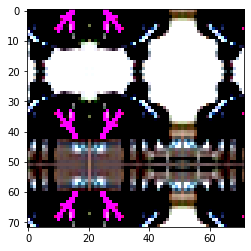

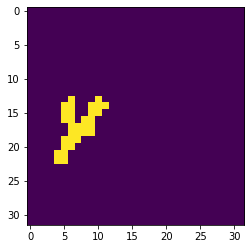

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


iter: 0, loss: 0.957054615020752, acc: 48.4375, mIoU: 25.713487963941684
iter: 1, loss: 0.9564924240112305, acc: 48.73046875, mIoU: 25.874763922209176
iter: 2, loss: 0.9556543827056885, acc: 49.12109375, mIoU: 26.08999456425927
iter: 3, loss: 0.9545460939407349, acc: 50.48828125, mIoU: 26.845135996079396
iter: 4, loss: 0.95317542552948, acc: 51.3671875, mIoU: 27.332168790901996
iter: 5, loss: 0.9515494108200073, acc: 52.734375, mIoU: 28.162204724409452
iter: 6, loss: 0.9496743679046631, acc: 54.1015625, mIoU: 28.92914979757085
iter: 7, loss: 0.9475544691085815, acc: 55.6640625, mIoU: 29.886880617569556
iter: 8, loss: 0.945202112197876, acc: 57.51953125, mIoU: 31.106631583060867
iter: 9, loss: 0.9426276683807373, acc: 59.27734375, mIoU: 32.12780232589661
iter: 10, loss: 0.9398401975631714, acc: 61.1328125, mIoU: 33.216590949318544
iter: 11, loss: 0.9368442296981812, acc: 62.59765625, mIoU: 34.08506005822345
iter: 12, loss: 0.933651864528656, acc: 64.35546875, mIoU: 35.13896280678771
ite

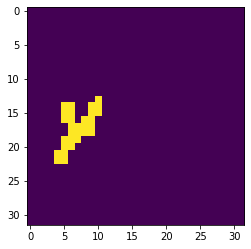

Evaluating on train data...
iter: 0/50000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


iter: 50/50000
iter: 100/50000
iter: 150/50000
iter: 200/50000
iter: 250/50000
iter: 300/50000
iter: 350/50000
iter: 400/50000
iter: 450/50000
iter: 500/50000
iter: 550/50000
iter: 600/50000
iter: 650/50000
iter: 700/50000
iter: 750/50000
iter: 800/50000
iter: 850/50000
iter: 900/50000
iter: 950/50000
iter: 1000/50000
iter: 1050/50000
iter: 1100/50000
iter: 1150/50000
iter: 1200/50000
iter: 1250/50000
iter: 1300/50000
iter: 1350/50000
iter: 1400/50000
iter: 1450/50000
iter: 1500/50000
iter: 1550/50000
iter: 1600/50000
iter: 1650/50000
iter: 1700/50000
iter: 1750/50000
iter: 1800/50000
iter: 1850/50000
iter: 1900/50000
iter: 1950/50000
iter: 2000/50000
iter: 2050/50000
iter: 2100/50000
iter: 2150/50000
iter: 2200/50000
iter: 2250/50000
iter: 2300/50000
iter: 2350/50000
iter: 2400/50000
iter: 2450/50000
iter: 2500/50000
iter: 2550/50000
iter: 2600/50000
iter: 2650/50000
iter: 2700/50000
iter: 2750/50000
iter: 2800/50000
iter: 2850/50000
iter: 2900/50000
iter: 2950/50000
iter: 3000/50000


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iter: 50/50000
iter: 100/50000
iter: 150/50000
iter: 200/50000
iter: 250/50000
iter: 300/50000
iter: 350/50000
iter: 400/50000
iter: 450/50000
iter: 500/50000
iter: 550/50000
iter: 600/50000
iter: 650/50000
iter: 700/50000
iter: 750/50000
iter: 800/50000
iter: 850/50000
iter: 900/50000
iter: 950/50000
iter: 1000/50000
iter: 1050/50000
iter: 1100/50000
iter: 1150/50000
iter: 1200/50000
iter: 1250/50000
iter: 1300/50000
iter: 1350/50000
iter: 1400/50000
iter: 1450/50000
iter: 1500/50000
iter: 1550/50000
iter: 1600/50000
iter: 1650/50000
iter: 1700/50000
iter: 1750/50000
iter: 1800/50000
iter: 1850/50000
iter: 1900/50000
iter: 1950/50000
iter: 2000/50000
iter: 2050/50000
iter: 2100/50000
iter: 2150/50000
iter: 2200/50000
iter: 2250/50000
iter: 2300/50000
iter: 2350/50000
iter: 2400/50000
iter: 2450/50000
iter: 2500/50000
iter: 2550/50000
iter: 2600/50000
iter: 2650/50000
iter: 2700/50000
iter: 2750/50000
iter: 2800/50000
iter: 2850/50000
iter: 2900/50000
iter: 2950/50000
iter: 3000/50000


In [ ]:
""" main.py """

import torch
import time
import numpy as np
# from tensorboardX import SummaryWriter

# from utils.log_utils import start_logging, end_logging, log_metrics, log_params
# from utils.train_utils import get_criterion, get_optimizer, make_training_step
# from utils.debug_utils import overfit_on_batch
# from utils.data_utils import get_dataloader
# from utils.eval_utils import evaluate
# from models.unet_small import get_model
# from configs.config import cfg


def train(model, criterion, opt, train_dl, valid_dl):

    # restore model if necessary
    global_step, start_epoch = 0, 0
    if cfg.load_model:
        print(f'Trying to load checkpoint from epoch {cfg.epoch_to_load}...')
        checkpoint = torch.load(cfg.checkpoints_dir + f'checkpoint_{cfg.epoch_to_load}.pth')
        load_state_dict = checkpoint['model']
        model.load_state_dict(load_state_dict)
        start_epoch = checkpoint['epoch'] + 1
        global_step = checkpoint['global_step'] + 1
        print(f'Successfully loaded checkpoint from epoch {cfg.epoch_to_load}.')

    # evaluate on train and test data before training
    if cfg.evaluate_before_training:
        model.eval()
        with torch.no_grad():
            if cfg.evaluate_on_train_data:
                evaluate(cfg, model, train_dl, start_epoch - 1, 'train')
            evaluate(cfg, model, valid_dl, start_epoch - 1, 'valid')
        model.train()

    # training loop
    nb_iters_per_epoch = len(train_dl.dataset) // cfg.batch_size
    for epoch in range(start_epoch, cfg.epochs):
        losses = []
        epoch_start_time = time.time()
        print(f'Epoch: {epoch}')
        for iter_, batch in enumerate(train_dl):
            loss = make_training_step(batch, model, criterion, opt)
            losses.append(loss)
            global_step += 1

            log_metrics(['train/loss'], [loss], global_step, cfg)

            if global_step % 100 == 0:
                mean_loss = np.mean(losses[:-20]) if len(losses) > 20 else np.mean(losses)
                print(f'step: {global_step}, loss: {mean_loss}')

        # log mean loss per epoch
        log_metrics(['train/mean_loss'], [np.mean(losses[:-nb_iters_per_epoch])], epoch, cfg)
        print(f'Epoch time: {round((time.time() - epoch_start_time) / 60, 3)} min')

        # save model
        if cfg.save_model and epoch % cfg.save_frequency == 0:
            print('Saving current model...')
            state = {
                'model': model.state_dict(),
                'epoch': epoch,
                'global_step': global_step,
                'opt': opt.state_dict(),
            }
            torch.save(state, cfg.checkpoints_dir + f'checkpoint_{epoch}.pth')

        # evaluate on train and test data
        model.eval()
        with torch.no_grad():
            if cfg.evaluate_on_train_data:
                evaluate(cfg, model, train_dl, epoch, 'train')
            evaluate(cfg, model, valid_dl, epoch, 'valid')
        model.train()


if __name__ == '__main__':
    train_dl = get_dataloader('train')
    valid_dl = get_dataloader('valid')

    model = get_model(cfg)
    criterion = get_criterion()
    opt = get_optimizer(cfg, model)

    writer = SummaryWriter(cfg.tensorboard_dir) if cfg.use_tensorboard else None

    # check training procedure before training
    if cfg.overfit_on_batch:
        overfit_on_batch(model, opt, criterion, train_dl, writer=writer)

    # save experiment name and experiment params to mlflow
    start_logging(cfg)
    log_params(cfg)

    # train model
    start_time = time.time()
    train(model, criterion, opt, train_dl, valid_dl)
    print(f'Total time: {round((time.time() - start_time) / 60, 3)} min')

    # end logging
    end_logging(cfg)